In [1]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')

from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_sankey_diagram
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

In [2]:
model_path = '../../checkpoint/latest/finetuner_pft_all.pt'
model = loadcompass(model_path)

In [3]:
from scipy.stats import zscore

In [4]:
res = []

cancer_name_dict = {}
cancer_name_dict2 = {}
for cancer in ['All', 'BLCA', 'KIRC', 'SKCM', 'LUAD', 'STAD', 'GBM', 'LUSC' ]:
    df1 = pd.read_csv('./results/cancer/%s_shap_pft_nr.csv' % cancer, index_col=0)
    df2 = pd.read_csv('./results/cancer/%s_shap_pft_r.csv' % cancer, index_col = 0)    

    ## global feature importance
    nr = df1.abs().mean().to_frame(name = 'NR')
    r = df2.abs().mean().to_frame(name = 'R')
    df = nr.join(r)
    df['group'] = cancer

    cancer_name_dict[cancer] = '%s(n=%s)' % (cancer, len(df1))
    cancer_name_dict2[cancer] = '%s\n(n=%s)' % (cancer, len(df1))
    res.append(df)

In [5]:
concept_shap_abs = df1.abs()

In [6]:
dfa = pd.concat(res)
dfa.index.name = 'concept'
data = dfa.reset_index()

data['R/NR_mean'] = data[['R', 'NR']].mean(axis=1)
data['R/NR_std'] = data[['R', 'NR']].std(axis=1)

data1 = pd.pivot_table(data, values = 'R/NR_mean', index = 'concept', columns = 'group')

concept_shap_score = data1 

In [7]:
data

,concept,NR,R,group,R/NR_mean,R/NR_std
0,CANCER,0.038841,0.038841,All,0.038841,1.431827e-11
1,Bcell_general,0.017684,0.017684,All,0.017684,1.644910e-11
2,Memory_Bcell,0.030314,0.030314,All,0.030314,3.115329e-11
3,Naive_Bcell,0.006502,0.006502,All,0.006502,9.403808e-12
4,Plasma_cell,0.039375,0.039375,All,0.039375,1.064719e-11
...,...,...,...,...,...,...
347,Cytokine,0.035047,0.035047,LUSC,0.035047,3.906898e-11
348,Cell_proliferation,0.023553,0.023553,LUSC,0.023553,3.889601e-11
349,TLS,0.014020,0.014020,LUSC,0.014020,9.106676e-12
350,Genome_integrity,0.063724,0.063724,LUSC,0.063724,2.007290e-11


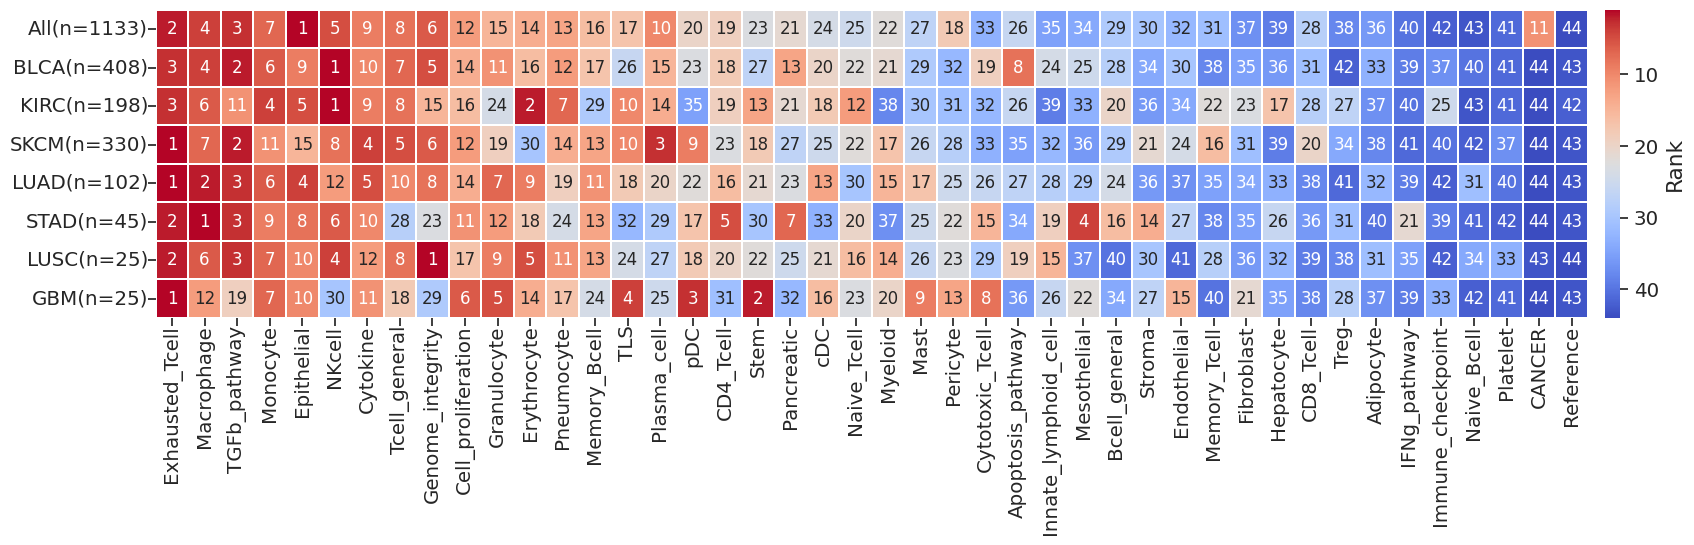

In [8]:
data_c = concept_shap_score.rank(axis=0, ascending=False)
order = data_c.mean(axis=1).sort_values(ascending=True).index
cols = ['All', 'BLCA', 'KIRC', 'SKCM', 'LUAD','STAD', 'LUSC', 'GBM']
cols_name = [cancer_name_dict[i] for i in cols]

data_c = data_c.loc[order][cols]

fig, ax = plt.subplots(figsize=(22,4))
g = sns.heatmap(data_c.T, ax=ax, annot=True, annot_kws={'fontsize':12,}, cbar_kws={ "pad": 0.01, 'label':'Rank'}, cmap = 'coolwarm_r', linewidths = 0.005,)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.set_yticklabels(cols_name)

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

cbar = g.collections[0].colorbar
cbar.ax.invert_yaxis()

fig.savefig('./results/01_top_ranked_concepts.svg', bbox_inches='tight')

In [9]:
level1 = 'gene->geneset'
level2 = 'geneset->celltype'

res1 = []
res2 = []
for cancer in ['BLCA', 'KIRC', 'SKCM', 'LUAD',  'GBM', 'LUSC' , 'STAD',]:

    x =  concept_shap_score[cancer]
    x = (x - x.min()) / (x.max() - x.min())

    flow_shap_df, _ = plot_sankey_diagram(model, concept2plot= concept_shap_score.index, scale_imp = True,
                                          concept_imp_dict = x.to_dict(), font=dict(size=20,   color='black'),  )

    #dfg = flow_shap_df.groupby(['group', 'source']).weights.sum().reset_index()
    
    dfg = flow_shap_df[ flow_shap_df.group == level1].set_index('source').weights.to_frame('abs_shap')
    
    dfg['std'] =  0.0
    dfg['group'] = cancer 
    
    dfs = flow_shap_df[ flow_shap_df.group == level2].set_index('source').weights.to_frame('abs_shap')
    dfs['std'] =  0.0
    dfs['group'] = cancer
    
    res1.append(dfg)
    res2.append(dfs)

df1 = pd.concat(res1).reset_index()
data_gene = pd.pivot_table(data = df1, values = 'abs_shap', index = 'source', columns = ['group'], aggfunc= np.sum).astype(float)

df2 = pd.concat(res2).reset_index()
data_geneset = pd.pivot_table(data = df2, values = 'abs_shap', index = 'source', columns = ['group'], aggfunc= np.sum).astype(float)

In [10]:
len(data_gene), len(data_geneset)

(916, 132)

In [11]:
data_gene.loc['FCER2']

group
BLCA    0.157968
GBM     0.069960
KIRC    0.006622
LUAD    0.138517
LUSC    0.133531
SKCM    0.070939
STAD    0.023478
Name: FCER2, dtype: float64

In [12]:
data_gene.loc['CCR3']

group
BLCA    2.252737
GBM     3.451260
KIRC    0.798818
LUAD    2.465849
LUSC    4.211187
SKCM    2.097392
STAD    2.106774
Name: CCR3, dtype: float64

## geneset level

60


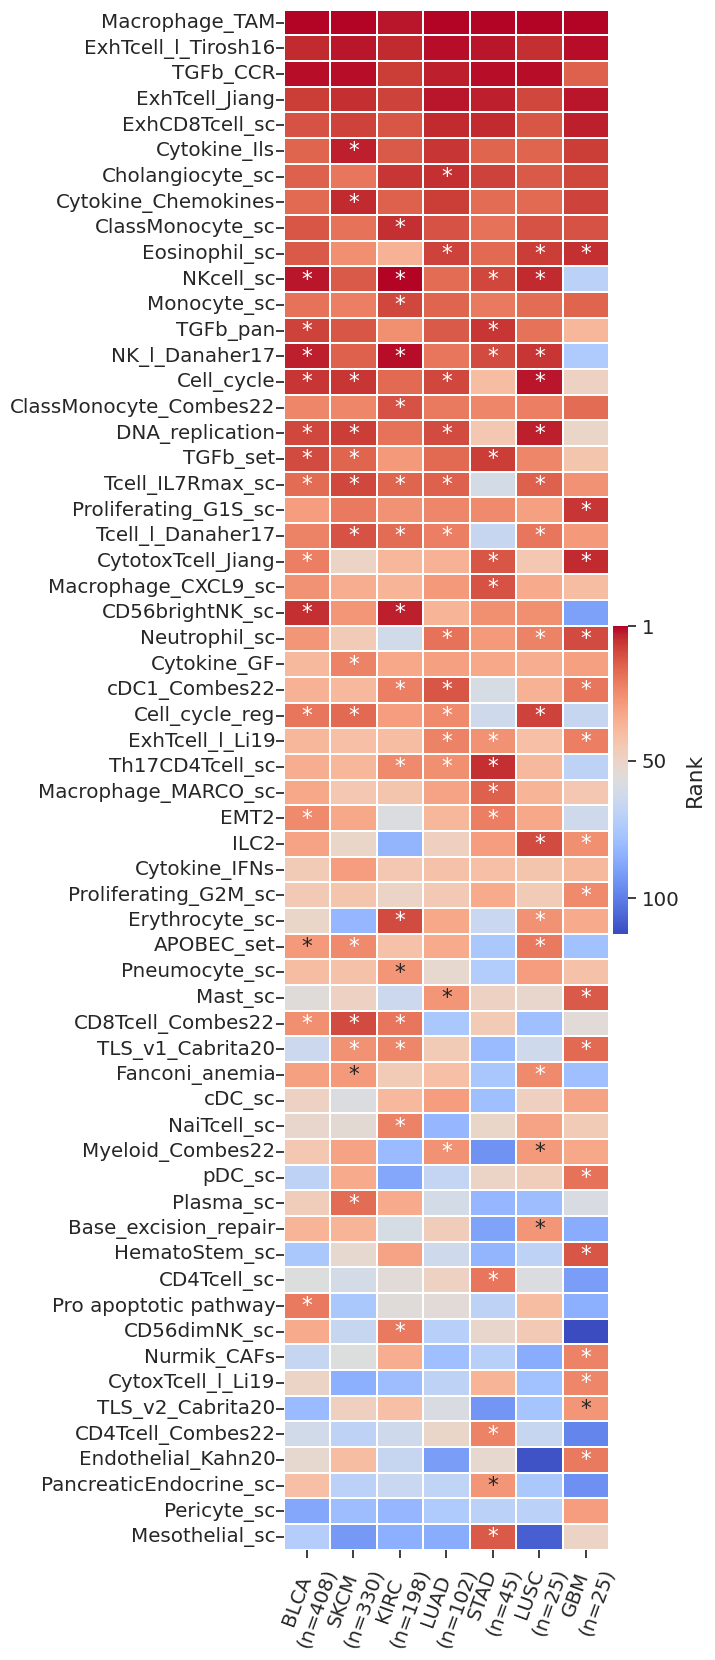

In [13]:
order = ['BLCA', 'SKCM', 'KIRC', 'LUAD', 'STAD', 'LUSC', 'GBM']
df = data_geneset.rank(ascending=False)[order]

top = 30

sgs = []
for i in order:
    sgs.extend(df.sort_values(i).head(top).index)

df = df.loc[list(set(sgs))]
df = df.loc[df.mean(axis=1).sort_values().index]

print(len(df))
markers = np.full(df.shape, '', dtype=object)

# 遍历每个基因集（行）
for i in range(df.shape[0]):
    # 获取当前基因集的所有排名
    ranks = df.iloc[i, :]
    # 计算其他所有癌症类型的中位数排名
    median_rank = ranks.mean()
    
    # 检查每个癌症类型的排名是否高出中位数排名5名次
    for j in range(df.shape[1]):
        if (ranks.iloc[j] < median_rank - 5) & (ranks.iloc[j] < top):
            markers[i, j] = '*'

fig, ax = plt.subplots(figsize=(5, 20),)
g = sns.heatmap(df ,yticklabels = True, annot=markers, fmt='', linewidths = 0.005,
                cmap='coolwarm_r', ax=ax, cbar_kws={'shrink': 0.2, 'pad':0.01, 'label':'Rank', 'ticks': [1, 50, 100]})
# for label in g.axes.get_yticklabels():
#     label.set_size(10)  # 可以调整这个值来改变字体大小
ax.set_ylabel(None)

ax.set_xticklabels([cancer_name_dict2[i] for i in df.columns])

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.0,)

cbar = g.collections[0].colorbar
cbar.ax.invert_yaxis()
ax.set_xlabel(None)
for label in ax.get_xticklabels():
    label.set_rotation(70, )

fig.savefig('./results/02_top_ranked_genesets.svg', bbox_inches='tight')

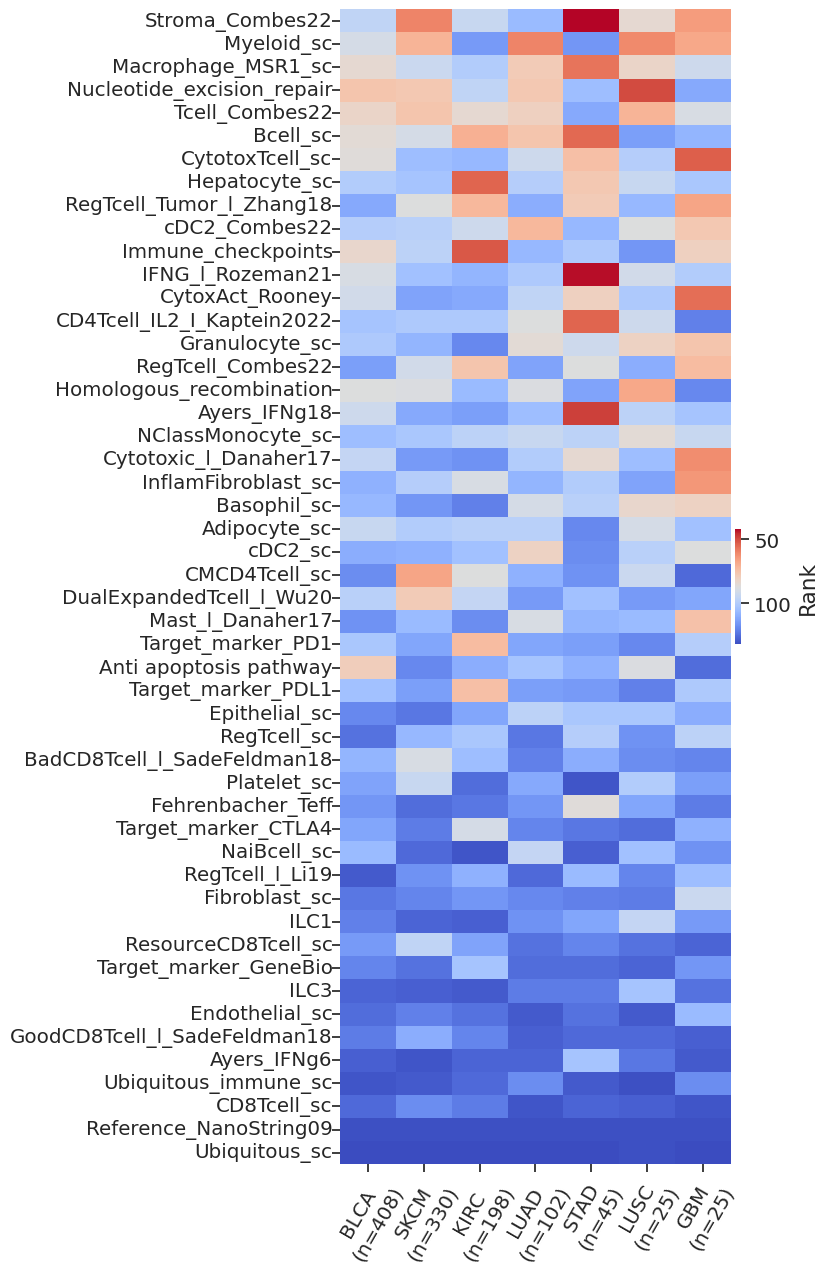

In [14]:
order = ['BLCA', 'SKCM', 'KIRC', 'LUAD', 'STAD', 'LUSC', 'GBM']
df = data_geneset.rank(ascending=False)[order]
df = df.loc[df.mean(axis=1).sort_values().index].tail(50)

fig, ax = plt.subplots(figsize=(6, 15),)
g = sns.heatmap(df ,yticklabels = True, #cbar = False,
                cmap='coolwarm_r', ax=ax, cbar_kws={'shrink': 0.1, 'pad':0.01, 'label':'Rank'})
# for label in g.axes.get_yticklabels():
#     label.set_size(10)  # 可以调整这个值来改变字体大小
ax.set_ylabel(None)

ax.set_xticklabels([cancer_name_dict2[i] for i in df.columns])

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

cbar = g.collections[0].colorbar
cbar.ax.invert_yaxis()
ax.set_xlabel(None)
for label in ax.get_xticklabels():
    label.set_rotation(60, )

#fig.savefig('./results/geneset_tail_ranked.svg', bbox_inches='tight')


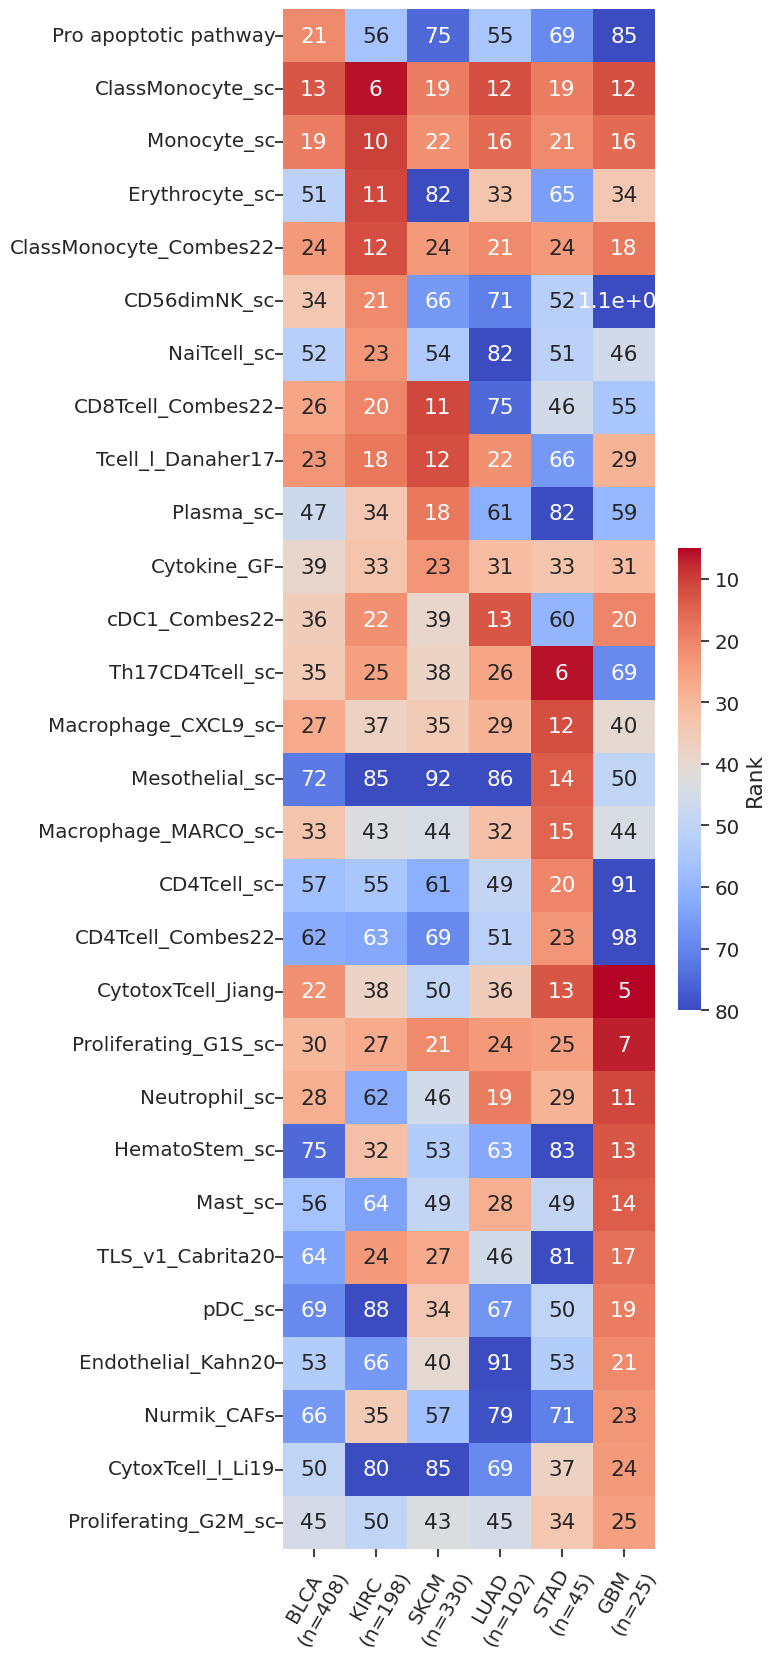

In [15]:
## cancer type specifc genesets

order = [ 'BLCA', 'KIRC',  'SKCM', 'LUAD',  'STAD',  'GBM'] #

df = data_geneset.rank(ascending=False)[order]
data_geneset_sorted_rank = df.loc[df.mean(axis=1).sort_values(ascending=True).index]
data_geneset_sorted_rank = data_geneset_sorted_rank

all_groups = data_geneset_sorted_rank.columns

res = []
for group in all_groups:
    x1 = data_geneset_sorted_rank[group]
    x2 = data_geneset_sorted_rank[all_groups.difference([group])].min(axis=1)
    
    diff = x1[(x2-x1) > 5].index
    
    top = data_geneset_sorted_rank.loc[diff]
    top = top.sort_values(group, ascending=True)
    top = top[top[group] < 0.20*len(data_geneset_sorted_rank)]
    res.append(top)


dfs = pd.concat(res)
fig, ax = plt.subplots(figsize=(len(order), 20))
g = sns.heatmap(dfs,  cmap='coolwarm_r', ax=ax , annot=True,  cbar_kws={'shrink': 0.3, 'label':'Rank'}, vmax = 80)
# ax.set_ylabel('Geneset')
# ax.set_xlabel('Cancer type')

ax.set_ylabel(None)

ax.set_xticklabels([cancer_name_dict2[i] for i in order])

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

cbar = g.collections[0].colorbar
cbar.ax.invert_yaxis()
ax.set_xlabel(None)

for label in ax.get_xticklabels():
    label.set_rotation(60, )
    
#fig.savefig('./results/geneset_cancer_specific.svg', bbox_inches='tight')

99


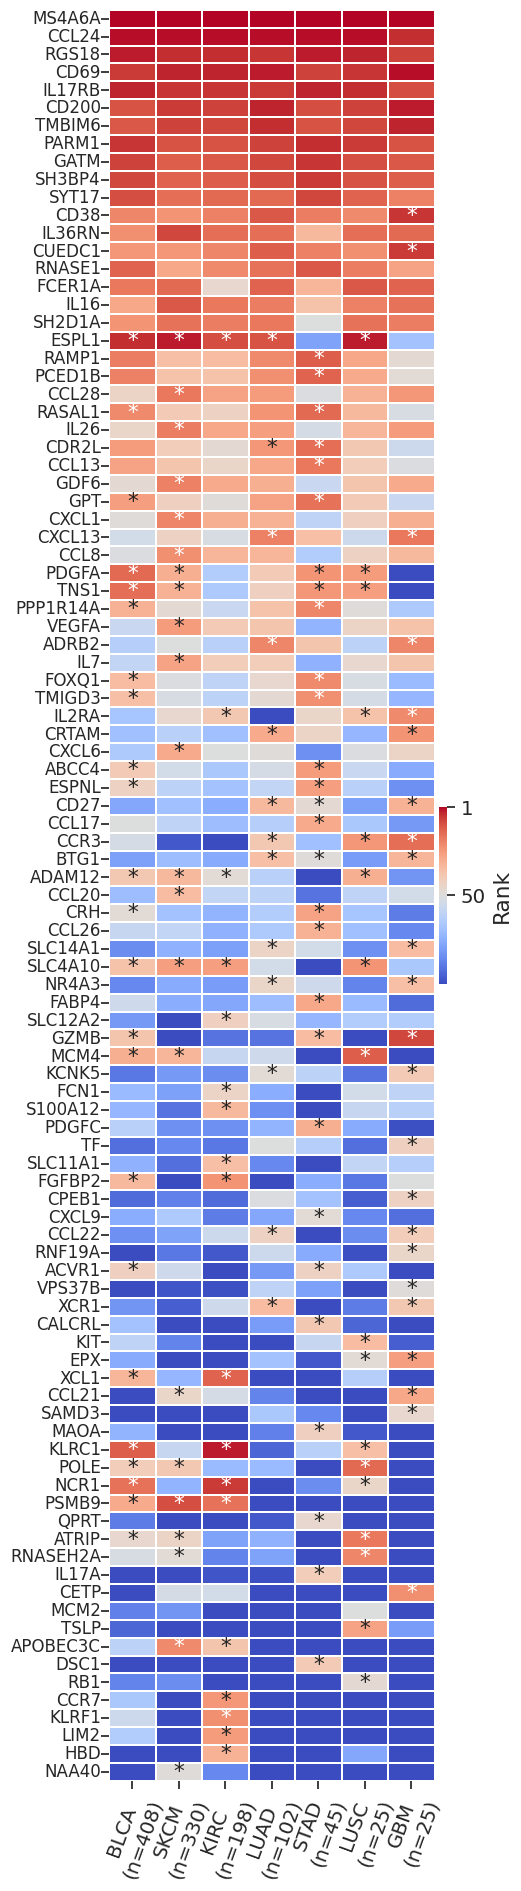

In [16]:
## gene level
order = ['BLCA', 'SKCM', 'KIRC', 'LUAD', 'STAD', 'LUSC', 'GBM']
df = data_gene.rank(ascending=False)[order]

top = 50

sgs = []
for i in order:
    sgs.extend(df.sort_values(i).head(top).index)

df = df.loc[list(set(sgs))]
df = df.loc[df.mean(axis=1).sort_values().index]
print(len(df))

markers = np.full(df.shape, '', dtype=object)

# 遍历每个基因集（行）
for i in range(df.shape[0]):
    # 获取当前基因集的所有排名
    ranks = df.iloc[i, :]
    # 计算其他所有癌症类型的中位数排名
    median_rank = ranks.mean()
    
    # 检查每个癌症类型的排名是否高出中位数排名5名次
    for j in range(df.shape[1]):
        if (ranks.iloc[j] < median_rank - 10) & (ranks.iloc[j] < top):
            markers[i, j] = '*'

fig, ax = plt.subplots(figsize=(5, 23),)
g = sns.heatmap(df ,yticklabels = True, annot=markers, fmt='', vmax = len(df), linewidths = 0.005,
                cmap='coolwarm_r', ax=ax, cbar_kws={'shrink': 0.1, 'pad':0.01, 'label':'Rank', 'ticks': [1, 50, 100]})
for label in g.axes.get_yticklabels():
    label.set_size(12)  # 可以调整这个值来改变字体大小
    
ax.set_ylabel(None)

ax.set_xticklabels([cancer_name_dict2[i] for i in df.columns])

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.0,)

cbar = g.collections[0].colorbar
cbar.ax.invert_yaxis()
ax.set_xlabel(None)
for label in ax.get_xticklabels():
    label.set_rotation(70, )


fig.savefig('./results/03_top_ranked_genes.svg', bbox_inches='tight')

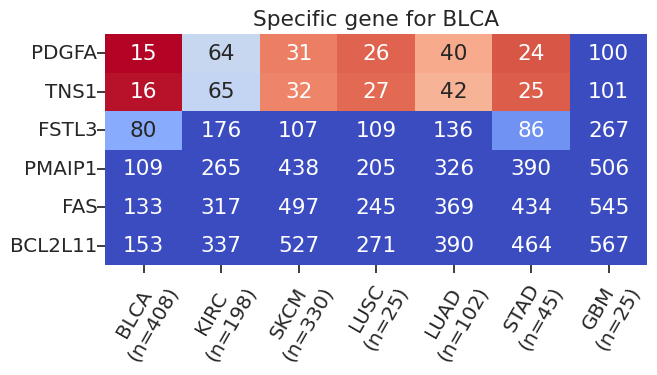

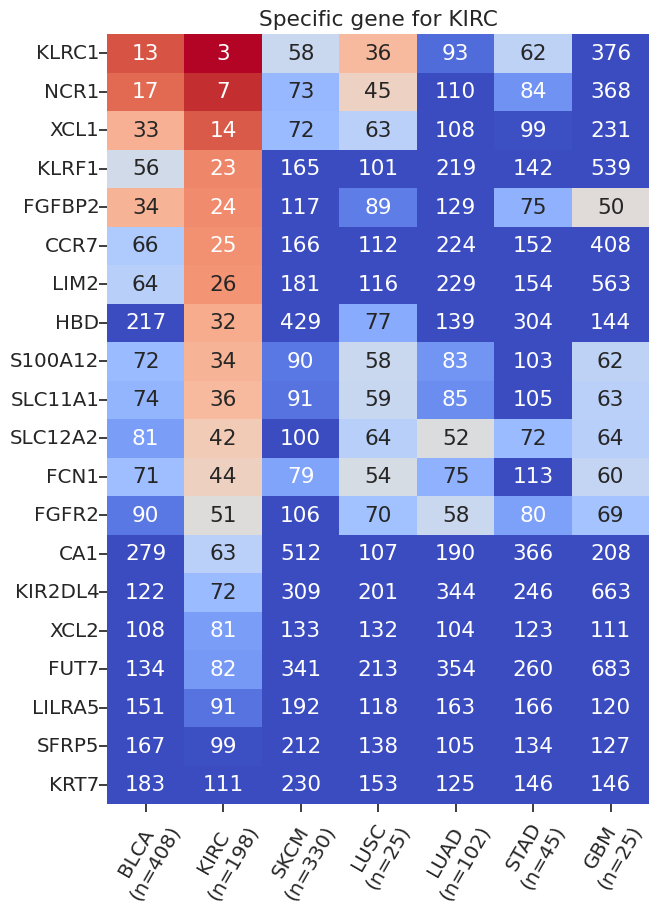

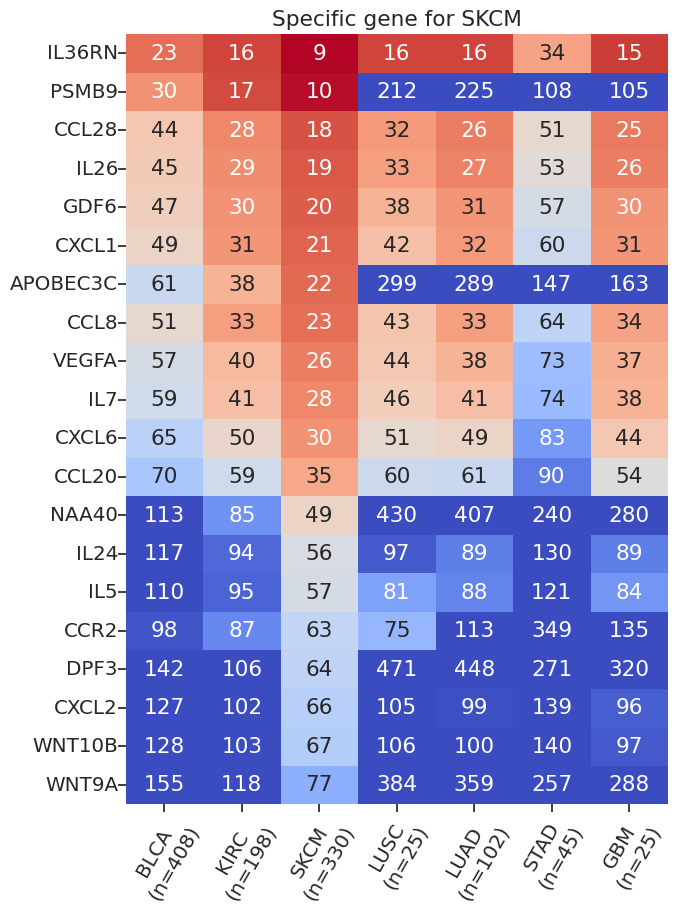

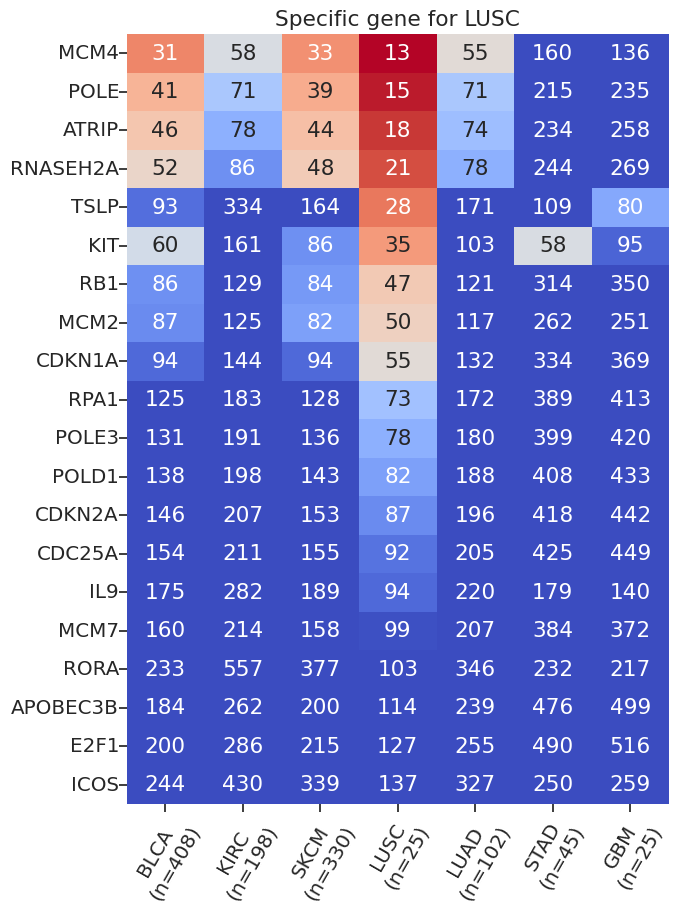

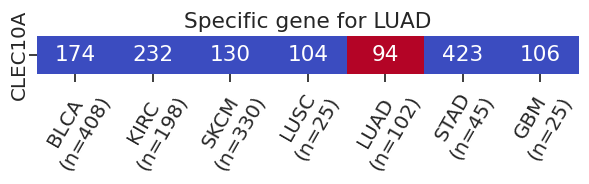

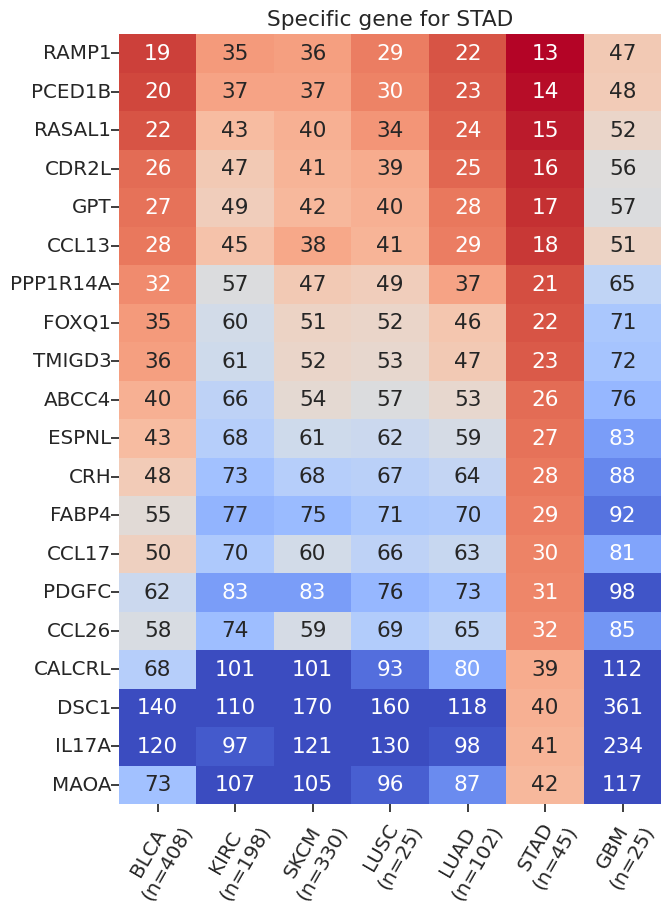

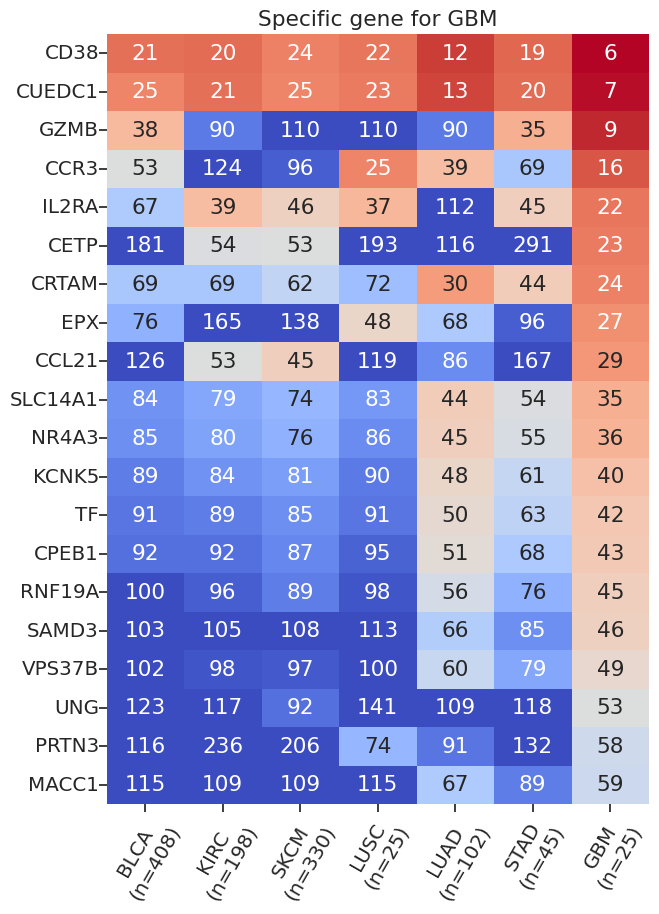

In [17]:
## cancer type specifc genesets

order = [ 'BLCA', 'KIRC',  'SKCM', 'LUSC',  'LUAD','STAD',  'GBM'] #'LUSC',

df = data_gene.rank(ascending=False)[order]
data_geneset_sorted_rank = df.loc[df.mean(axis=1).sort_values(ascending=True).index]
data_geneset_sorted_rank = data_geneset_sorted_rank

all_groups = data_geneset_sorted_rank.columns

res = []
for group in all_groups:
    x1 = data_geneset_sorted_rank[group]
    x2 = data_geneset_sorted_rank[all_groups.difference([group])].min(axis=1)

    
    diff = x1[(x2-x1) > 5].index
    
    top = data_geneset_sorted_rank.loc[diff]
    top = top.sort_values(group, ascending=True)
    top = top[top[group] < 0.20*len(data_geneset_sorted_rank)].head(20) 
    res.append(top)

    
for dfs, group in zip(res, all_groups):
    if len(dfs) == 0:
        continue
    #dfs = pd.concat(res)
    fig, ax = plt.subplots(figsize=(len(order), len(dfs)*0.5))
    g = sns.heatmap(dfs.astype(int),  cbar=False, cmap='coolwarm_r', ax=ax , cbar_kws={'shrink': 0.3, 'label':'Rank'}, vmax = 100, annot=True, fmt='d')#dfs[group].max()
    # ax.set_ylabel('Geneset')
    # ax.set_xlabel('Cancer type')
    
    ax.set_ylabel(None)
    
    ax.set_xticklabels([cancer_name_dict2[i] for i in order])
    
    ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
    
    # cbar = g.collections[0].colorbar
    # cbar.ax.invert_yaxis()
    ax.set_xlabel(None)
    
    for label in ax.get_xticklabels():
        label.set_rotation(60, )

    ax.set_title('Specific gene for %s' % group)
    
    fig.savefig('./results/CANCER_%s_specific_gene.svg' % group, bbox_inches='tight')

In [50]:
# ## gene level
# order = ['BLCA', 'SKCM', 'KIRC', 'LUAD', 'STAD', 'LUSC', 'GBM']
# df = data_gene.rank(ascending=False)[order]

# from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
# from scipy.spatial.distance import pdist

# # 计算行和列的层次聚类
# row_linkage = linkage(df, method='average')
# col_linkage = linkage(df.T, method='average')

# # 使用阈值对聚类树进行分割
# row_clusters = fcluster(row_linkage, t=5, criterion='maxclust')
# col_clusters = fcluster(col_linkage, t=3, criterion='distance')

# # 为每个聚类分配颜色
# unique_row_clusters = np.unique(row_clusters)
# unique_col_clusters = np.unique(col_clusters)

# row_palette = sns.color_palette('coolwarm', len(unique_row_clusters))
# col_palette = sns.color_palette('husl', len(unique_col_clusters))

# row_colors = [row_palette[i - 1] for i in row_clusters]
# col_colors = [col_palette[i - 1] for i in col_clusters]

# # 绘制聚类热图并显示不同颜色
# g = sns.clustermap(df, row_linkage=row_linkage, col_linkage=col_linkage,
#                    row_colors=row_colors, col_colors=col_colors, cmap='coolwarm_r', dendrogram_ratio = (0.2, 0.05),  figsize=(10, 20),)

# # 显示绘图
# #g.ax_heatmap.set_title('Clustered Heatmap with Colored Dendrograms')